In [8]:
from google.colab import drive
drive.mount("/content/drive")

!pip -q install timm pandas scikit-learn tqdm ipywidgets


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from pathlib import Path
import json, os, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

import timm
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display


In [10]:
PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")
assert PROJECT_ROOT.exists(), f"❌ PROJECT_ROOT not found: {PROJECT_ROOT}"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ✅ Update these if your checkpoint names differ
SKIN_TYPE_CKPT = PROJECT_ROOT / "models/vision/skin_type_convnext_cleaned_best.pt"
SKIN_CONCERN_CKPT = PROJECT_ROOT / "models/vision/skin_concerns_convnext_best.pt"

# ✅ Product catalog CSV
PRODUCT_CSV = PROJECT_ROOT / "data/product_catalog_skincare_10k.csv"

assert SKIN_TYPE_CKPT.exists(), f"❌ Missing skin type ckpt: {SKIN_TYPE_CKPT}"
assert SKIN_CONCERN_CKPT.exists(), f"❌ Missing concern ckpt: {SKIN_CONCERN_CKPT}"
assert PRODUCT_CSV.exists(), f"❌ Missing product CSV: {PRODUCT_CSV}"

print("✅ Skin type ckpt:", SKIN_TYPE_CKPT.name)
print("✅ Concern ckpt :", SKIN_CONCERN_CKPT.name)
print("✅ Product CSV  :", PRODUCT_CSV.name)


Device: cpu
✅ Skin type ckpt: skin_type_convnext_cleaned_best.pt
✅ Concern ckpt : skin_concerns_convnext_best.pt
✅ Product CSV  : product_catalog_skincare_10k.csv


In [11]:
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def show_image(path):
    img = Image.open(path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

def softmax_np(x):
    x = x - np.max(x)
    e = np.exp(x)
    return e / (e.sum() + 1e-9)


In [12]:
skin_type_ckpt = torch.load(SKIN_TYPE_CKPT, map_location=DEVICE)
skin_type_label_map = skin_type_ckpt["label_map"]
skin_type_id2label = {v:k for k,v in skin_type_label_map.items()}
skin_type_num_classes = len(skin_type_label_map)

skin_type_model = timm.create_model(
    skin_type_ckpt.get("model_name", "convnext_tiny"),
    pretrained=False,
    num_classes=skin_type_num_classes
).to(DEVICE)

skin_type_model.load_state_dict(skin_type_ckpt["model_state"], strict=True)
skin_type_model.eval()

@torch.no_grad()
def predict_skin_type(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)
    logits = skin_type_model(x).cpu().numpy().flatten()
    probs = softmax_np(logits)
    pred = int(np.argmax(probs))
    return probs, pred

print("✅ Skin type model loaded.")


✅ Skin type model loaded.


In [13]:
conc_ckpt = torch.load(SKIN_CONCERN_CKPT, map_location=DEVICE)
conc_label_map = conc_ckpt["label_map"]
conc_id2label = {v:k for k,v in conc_label_map.items()}
conc_num_classes = len(conc_label_map)

conc_model = timm.create_model(
    conc_ckpt.get("model_name", "convnext_tiny"),
    pretrained=False,
    num_classes=conc_num_classes
).to(DEVICE)

conc_model.load_state_dict(conc_ckpt["model_state"], strict=True)
conc_model.eval()

@torch.no_grad()
def predict_concern(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(DEVICE)
    logits = conc_model(x).cpu().numpy().flatten()
    probs = softmax_np(logits)
    pred = int(np.argmax(probs))
    return probs, pred

print("✅ Concern model loaded.")


✅ Concern model loaded.


Choose image input method:
1) Upload from laptop
2) Use camera (webcam)
Enter 1 or 2: 1


Saving WhatsApp Image 2026-01-02 at 10.42.38.jpeg to WhatsApp Image 2026-01-02 at 10.42.38.jpeg

✅ Image saved to: /content/drive/MyDrive/SkinCare_AI_Component/uploads/WhatsApp Image 2026-01-02 at 10.42.38.jpeg


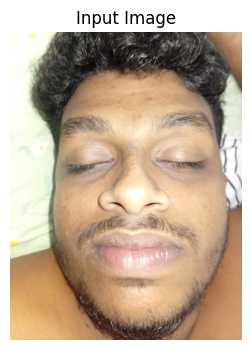

In [14]:
UPLOAD_DIR = PROJECT_ROOT / "uploads"
UPLOAD_DIR.mkdir(parents=True, exist_ok=True)

def save_bytes_to_file(data: bytes, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "wb") as f:
        f.write(data)

def upload_image():
    from google.colab import files
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("❌ No file uploaded.")
    name = list(uploaded.keys())[0]
    out_path = UPLOAD_DIR / name
    save_bytes_to_file(uploaded[name], out_path)
    return out_path

def capture_from_camera_safe():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    import base64

    display(Javascript(r'''
        async function takePhotoSafe() {
          try {
            const div = document.createElement('div');
            div.style.padding = "10px";
            div.style.border = "1px solid #ddd";
            div.style.borderRadius = "10px";
            div.style.width = "360px";

            const title = document.createElement('div');
            title.textContent = "Camera preview (allow permission if asked)";
            title.style.fontWeight = "600";
            title.style.marginBottom = "8px";

            const video = document.createElement('video');
            video.style.width = "340px";
            video.style.borderRadius = "10px";
            video.autoplay = true;

            const btn = document.createElement('button');
            btn.textContent = '📸 Capture';
            btn.style.marginTop = "10px";
            btn.style.padding = "8px 12px";

            div.appendChild(title);
            div.appendChild(video);
            div.appendChild(btn);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;

            await new Promise((resolve) => btn.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return {ok: true, dataUrl: canvas.toDataURL('image/jpeg', 0.95)};
          } catch (err) {
            return {ok: false, error: String(err)};
          }
        }
    '''))

    res = eval_js('takePhotoSafe()')

    if not res or not res.get("ok", False):
        print("\n❌ Camera capture failed:", res.get("error", "Unknown error"))
        print("✅ Fix: Browser 🔒 icon → Site settings → Camera → Allow → Refresh Colab.")
        print("➡️ Falling back to Upload now.")
        return None

    data_url = res["dataUrl"]
    _, encoded = data_url.split(",", 1)
    img_bytes = base64.b64decode(encoded)

    filename = f"camera_{int(time.time())}.jpg"
    out_path = UPLOAD_DIR / filename
    save_bytes_to_file(img_bytes, out_path)
    return out_path

print("Choose image input method:")
print("1) Upload from laptop")
print("2) Use camera (webcam)")
choice = input("Enter 1 or 2: ").strip()

img_path = None
if choice == "2":
    img_path = capture_from_camera_safe()
if img_path is None:
    img_path = upload_image()

print("\n✅ Image saved to:", img_path)
show_image(img_path)


In [15]:
def ask_yes_no(q):
    while True:
        a = input(q + " (Yes/No): ").strip().lower()
        if a in ["yes","y"]: return 1
        if a in ["no","n"]: return 0
        print("❌ Please type Yes or No.")

print("\n🧾 Quick Questions (for safer recommendations)\n")
sensitive = ask_yes_no("1) Do you have sensitive skin (stings easily)?")
allergy_fragrance = ask_yes_no("2) Do you react to fragrance/perfume in skincare?")
goal = input("3) What is your main goal? (glow / acne / oil-control / hydration / spots): ").strip().lower()

print("\n✅ Saved profile:")
print("Sensitive:", bool(sensitive))
print("Fragrance allergy:", bool(allergy_fragrance))
print("Goal:", goal)



🧾 Quick Questions (for safer recommendations)

1) Do you have sensitive skin (stings easily)? (Yes/No): Yes
2) Do you react to fragrance/perfume in skincare? (Yes/No): No
3) What is your main goal? (glow / acne / oil-control / hydration / spots): glow

✅ Saved profile:
Sensitive: True
Fragrance allergy: False
Goal: glow


In [16]:
skin_probs, skin_pred = predict_skin_type(str(img_path))
conc_probs, conc_pred = predict_concern(str(img_path))

skin_label = skin_type_id2label[skin_pred]
conc_label = conc_id2label[conc_pred]

print("\n📌 AI Analysis")
print("✅ Skin type:", skin_label)
print("✅ Main concern:", conc_label)

print("\nSkin type probs:")
for i in range(skin_type_num_classes):
    print(f"{skin_type_id2label[i]:<15} {skin_probs[i]:.4f}")

print("\nConcern probs:")
for i in range(conc_num_classes):
    print(f"{conc_id2label[i]:<25} {conc_probs[i]:.4f}")



📌 AI Analysis
✅ Skin type: oily
✅ Main concern: acne_pimples

Skin type probs:
oily            0.9972
dry             0.0022
combination     0.0006

Concern probs:
acne_pimples              0.6442
redness_irritation        0.2616
dark_spots_uneven_tone    0.0325
dryness_flaking           0.0027
normal_clear              0.0590


In [17]:
catalog_df = pd.read_csv(PRODUCT_CSV)
catalog_df["ingredient_list"] = catalog_df["key_ingredients"].apply(lambda x: [i.strip() for i in str(x).split(",") if str(x).strip()])
catalog_df["tag_list"] = catalog_df["tags"].apply(lambda x: [t.strip() for t in str(x).split(",") if str(x).strip()])

print("✅ Catalog loaded:", len(catalog_df))
catalog_df.head()


✅ Catalog loaded: 10000


,product_id,product_name,brand,category,key_ingredients,tags,price_range,ingredient_list,tag_list
0,P00001,DermaGlow Hydrating Moisturizer,DermaGlow,moisturizer,"essential_oils,glycolic_acid,hyaluronic_acid,m...","all_skin,combo_safe,fragrance_free",budget,"[essential_oils, glycolic_acid, hyaluronic_aci...","[all_skin, combo_safe, fragrance_free]"
1,P00002,GlowLab Brightening Barrier Cream,GlowLab,moisturizer,"arbutin,ferulic_acid,fragrance,glycolic_acid,urea","all_skin,combo_safe",mid,"[arbutin, ferulic_acid, fragrance, glycolic_ac...","[all_skin, combo_safe]"
2,P00003,PureDerm Clear Gel Cleanser,PureDerm,cleanser,"azelaic_acid,hyaluronic_acid,niacinamide,panth...","all_skin,combo_safe,fragrance_free",premium,"[azelaic_acid, hyaluronic_acid, niacinamide, p...","[all_skin, combo_safe, fragrance_free]"
3,P00004,DermaGlow Soothing Calming Serum,DermaGlow,treatment_redness,"alcohol_denat,allantoin,ceramides,ferulic_acid...","all_skin,combo_safe,dry_safe,fragrance_free,se...",budget,"[alcohol_denat, allantoin, ceramides, ferulic_...","[all_skin, combo_safe, dry_safe, fragrance_fre..."
4,P00005,SkinNova Clear BHA Treatment,SkinNova,treatment_acne,"allantoin,centella_asiatica,essential_oils,fer...","acne_friendly,all_skin,combo_safe,oily_safe",mid,"[allantoin, centella_asiatica, essential_oils,...","[acne_friendly, all_skin, combo_safe, oily_safe]"


In [18]:
all_ingredients = sorted({ing for lst in catalog_df["ingredient_list"] for ing in lst})

print("🧾 Select ingredients you are allergic/sensitive to (checkboxes)")

checkboxes = [widgets.Checkbox(description=ing, value=False) for ing in all_ingredients]
grid = widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))
display(grid)

btn = widgets.Button(description="Save Allergies", button_style="success")
out = widgets.Output()
display(btn, out)

user_allergies = set()

def save_allergies(_):
    global user_allergies
    user_allergies = {cb.description for cb in checkboxes if cb.value}
    with out:
        out.clear_output()
        print("✅ Saved allergies:", sorted(list(user_allergies)) if user_allergies else "None")

btn.on_click(save_allergies)


🧾 Select ingredients you are allergic/sensitive to (checkboxes)


GridBox(children=(Checkbox(value=False, description='adapalene'), Checkbox(value=False, description='alcohol_d…

Button(button_style='success', description='Save Allergies', style=ButtonStyle())

Output()

In [19]:
def skin_type_tags(st):
    st = st.lower()
    if "oily" in st:
        return {"oily_safe", "combo_safe", "all_skin"}
    if "dry" in st:
        return {"dry_safe", "combo_safe", "all_skin"}
    return {"combo_safe", "all_skin"}

def filter_products(category, skin_type, sensitive, fragrance_allergy, forbidden_ingredients, top_k=3):
    required = skin_type_tags(skin_type)

    if sensitive:
        required.add("sensitive_safe")
    if fragrance_allergy:
        required.add("fragrance_free")

    df = catalog_df[catalog_df["category"] == category].copy()

    # remove allergens
    df = df[df["ingredient_list"].apply(lambda lst: not any(i in forbidden_ingredients for i in lst))]

    # apply tag requirements
    df = df[df["tag_list"].apply(lambda tags: required.issubset(set(tags)))]

    # fallback (relax)
    if len(df) < top_k:
        df = catalog_df[catalog_df["category"] == category].copy()
        df = df[df["ingredient_list"].apply(lambda lst: not any(i in forbidden_ingredients for i in lst))]

    return df.head(top_k)

routine_categories = {
    "AM": ["cleanser", "moisturizer", "sunscreen"],
    "PM": ["cleanser", "moisturizer"]
}

if conc_label == "acne_pimples":
    routine_categories["PM"].insert(1, "treatment_acne")
elif conc_label == "dark_spots_uneven_tone":
    routine_categories["AM"].insert(2, "treatment_spots")
elif conc_label == "dryness_flaking":
    routine_categories["PM"].insert(1, "treatment_dryness")
elif conc_label == "redness_irritation":
    routine_categories["PM"].insert(1, "treatment_redness")

product_routine = {"AM": [], "PM": []}

for period in ["AM","PM"]:
    for cat in routine_categories[period]:
        opts = filter_products(
            category=cat,
            skin_type=skin_label,
            sensitive=bool(sensitive),
            fragrance_allergy=bool(allergy_fragrance),
            forbidden_ingredients=user_allergies,
            top_k=3
        )
        product_routine[period].append((cat, opts))

print("✅ Product routine prepared.")


✅ Product routine prepared.


In [20]:
print("\n" + "="*70)
print("🧴 PERSONAL SKIN CARE ASSISTANT — FINAL OUTPUT")
print("="*70)

print(f"\n✅ Detected Skin Type      : {skin_label.upper()}")
print(f"✅ Main Visible Concern    : {conc_label.replace('_',' ').title()}")
print(f"✅ User Goal               : {goal}")

# allergies
print("\n🧪 Allergy / Sensitivity Filter:")
if user_allergies:
    print("✅ Allergic/Sensitive to:", ", ".join(sorted(list(user_allergies))))
else:
    print("✅ No allergies selected.")

# helper to print product options
def print_product_block(df_opts, max_items=3):
    if df_opts is None or len(df_opts) == 0:
        print("  ❌ No safe options found from catalog.")
        return
    for k, (_, r) in enumerate(df_opts.head(max_items).iterrows(), start=1):
        print(f"  Option {k}: {r['product_name']}  | Brand: {r['brand']}  | Tier: {r['price_range']}")
        print(f"           Key Ingredients: {r['key_ingredients']}")

print("\n🌞 Morning Routine (AM):")
for cat, df_opts in product_routine["AM"]:
    title = cat.replace("_", " ").title()
    print(f"\n- {title}")
    print_product_block(df_opts)

print("\n🌙 Night Routine (PM):")
for cat, df_opts in product_routine["PM"]:
    title = cat.replace("_", " ").title()
    print(f"\n- {title}")
    print_product_block(df_opts)

# extra notes based on sensitivity flags
print("\n📝 Notes:")
notes = []
if sensitive:
    notes.append("Sensitive skin: introduce new products slowly (patch test).")
if allergy_fragrance:
    notes.append("Avoid fragrance/perfume products; assistant filtered fragrance-free tags where possible.")
if conc_label == "acne_pimples":
    notes.append("Acne: avoid picking; use non-comedogenic products and be consistent for 6–8 weeks.")
if conc_label == "dark_spots_uneven_tone":
    notes.append("Dark spots: daily sunscreen is essential; results take time (6–12 weeks).")
if conc_label == "dryness_flaking":
    notes.append("Dryness: avoid over-cleansing; focus on barrier repair and hydration.")
if conc_label == "redness_irritation":
    notes.append("Redness/irritation: avoid harsh actives; prioritize soothing/barrier products.")

if goal:
    notes.append(f"Goal focus: {goal}")

for n in notes:
    print(" -", n)

print("\n⚠️ Disclaimer: This is not a medical diagnosis. If symptoms are severe "
      "(pain, swelling, oozing, intense itching), consult a dermatologist.")



🧴 PERSONAL SKIN CARE ASSISTANT — FINAL OUTPUT

✅ Detected Skin Type      : OILY
✅ Main Visible Concern    : Acne Pimples
✅ User Goal               : glow

🧪 Allergy / Sensitivity Filter:
✅ Allergic/Sensitive to: allantoin, arbutin, fragrance, zinc_oxide

🌞 Morning Routine (AM):

- Cleanser
  Option 1: ClearTone Brightening Foaming Cleanser  | Brand: ClearTone  | Tier: budget
           Key Ingredients: benzoyl_peroxide,glycolic_acid,hyaluronic_acid,panthenol,salicylic_acid,titanium_dioxide,tranexamic_acid,vitamin_c
  Option 2: GlowLab Clear Foaming Cleanser  | Brand: GlowLab  | Tier: mid
           Key Ingredients: glycerin,green_tea,hyaluronic_acid,titanium_dioxide,urea
  Option 3: DermaGlow Calming Foaming Cleanser  | Brand: DermaGlow  | Tier: budget
           Key Ingredients: benzoyl_peroxide,essential_oils,glycerin,hyaluronic_acid,titanium_dioxide

- Moisturizer
  Option 1: DermaGlow Pure Gel Cream  | Brand: DermaGlow  | Tier: premium
           Key Ingredients: adapalene,alcohol

In [21]:
from datetime import datetime

PROFILE_DIR = PROJECT_ROOT / "results/user_profiles"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)

USER_ID = "user_001"
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

profile = {
    "user_id": USER_ID,
    "timestamp": ts,
    "skin_type": skin_label,
    "skin_concern": conc_label,
    "goal": goal,
    "sensitive": bool(sensitive),
    "fragrance_allergy": bool(allergy_fragrance),
    "allergies": list(user_allergies),
    "routine": {
        period: [
            {
                "category": cat,
                "products": df_opts[["product_id","product_name","brand","price_range"]].to_dict("records")
            }
            for cat, df_opts in product_routine[period]
        ]
        for period in ["AM","PM"]
    }
}

out_path = PROFILE_DIR / f"{USER_ID}_{ts}.json"
with open(out_path, "w") as f:
    json.dump(profile, f, indent=2)

print("✅ Saved profile memory:", out_path)


✅ Saved profile memory: /content/drive/MyDrive/SkinCare_AI_Component/results/user_profiles/user_001_20260103_091811.json


In [22]:
from datetime import datetime
import json

PROFILE_DIR = PROJECT_ROOT / "results/user_profiles"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)

USER_ID = input("Enter user id (example: user_001): ").strip() or "user_001"
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

profile = {
    "user_id": USER_ID,
    "timestamp": ts,
    "skin_type": skin_label,
    "skin_concern": conc_label,
    "goal": goal,
    "sensitive": bool(sensitive),
    "fragrance_allergy": bool(allergy_fragrance),
    "allergies": sorted(list(user_allergies)),
    "recommended_products": {
        period: [
            {
                "category": cat,
                "products": df_opts[["product_id","product_name","brand","price_range","key_ingredients"]].to_dict("records")
            }
            for cat, df_opts in product_routine[period]
        ]
        for period in ["AM","PM"]
    }
}

out_path = PROFILE_DIR / f"{USER_ID}_{ts}.json"
with open(out_path, "w") as f:
    json.dump(profile, f, indent=2)

print("✅ Saved user profile:", out_path)


Enter user id (example: user_001): user_009
✅ Saved user profile: /content/drive/MyDrive/SkinCare_AI_Component/results/user_profiles/user_009_20260103_091847.json


In [23]:
import json
from pathlib import Path

PROFILE_DIR = PROJECT_ROOT / "results/user_profiles"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)

USER_ID = "user_001"  # change if needed

profiles = sorted(PROFILE_DIR.glob(f"{USER_ID}_*.json"))
latest_profile = profiles[-1] if profiles else None

saved_allergies = set()
saved_sensitive = None
saved_fragrance_allergy = None
saved_goal = None

if latest_profile:
    with open(latest_profile, "r") as f:
        mem = json.load(f)

    saved_allergies = set(mem.get("allergies", []))
    saved_sensitive = mem.get("sensitive", None)
    saved_fragrance_allergy = mem.get("fragrance_allergy", None)
    saved_goal = mem.get("goal", None)

    print("✅ Loaded previous user memory:", latest_profile.name)
    print("Saved allergies:", sorted(list(saved_allergies)) if saved_allergies else "None")
else:
    print("ℹ️ No saved memory yet for", USER_ID)


✅ Loaded previous user memory: user_001_20260103_091811.json
Saved allergies: ['allantoin', 'arbutin', 'fragrance', 'zinc_oxide']
